<a href="https://colab.research.google.com/github/fdavidsen/Braincore-Intern/blob/main/Braincore_Intern_2_YOLO_%2B_TrOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalasi Persiapan Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ROOT_DIR = '/content/drive/MyDrive/Braincore Intern/Week 2/'
DATA_PATH = ROOT_DIR + 'sirekap-dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pelatihan Model

In [ ]:
!pip install ultralytics

## Prepare OCR Dataset

In [ ]:
from ultralytics import YOLO
model = YOLO(ROOT_DIR + 'YOLO_train/weights/best.pt')

In [ ]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

df_list = []
for file_path in os.listdir(ROOT_DIR + 'sirekap-dataset/train/images'):
    labels = file_path.split('.')[0].split('_')[:3]
    image = Image.open(ROOT_DIR + 'sirekap-dataset/train/images/' + file_path).convert('RGB')
    results = model(ROOT_DIR + 'sirekap-dataset/train/images/' + file_path)

    # Iterate through detected bounding boxes
    for i, bounding_box in enumerate(results[0].boxes):
        # Extract bounding box coordinates as tensors
        x_min, y_min, x_max, y_max = bounding_box.xyxy[0]

        # Convert tensor coordinates to Python numbers
        x_min, y_min, x_max, y_max = x_min.item(), y_min.item(), x_max.item(), y_max.item()

        # Optionally, round or convert coordinates to integers if needed
        x_min, y_min, x_max, y_max = map(int, (x_min, y_min, x_max, y_max))

        # Crop the image using the bounding box coordinates
        cropped_image = image.crop((x_min, y_min, x_max, y_max))

        detected_class = int(bounding_box.cls.item())
        filename = str(detected_class) + '-' + file_path

        cropped_image.save(ROOT_DIR + 'ocr-train-dataset/' + filename)
        label = labels[detected_class]
        df_list.append([filename, label])

df = pd.DataFrame(df_list, columns=['filename', 'label'])
df.to_csv(ROOT_DIR + 'ocr-train-labels.csv', index=False)

In [ ]:
import pandas as pd

df = pd.read_csv(ROOT_DIR + 'ocr-train-labels.csv')
df.head()

,filename,label
0,0-66_136_9_jpg.rf.097fc9ae4f677817b667e9fa9291...,66
1,1-66_136_9_jpg.rf.097fc9ae4f677817b667e9fa9291...,136
2,2-66_136_9_jpg.rf.097fc9ae4f677817b667e9fa9291...,9
3,0-8_140_32_jpg.rf.466b87924e3a90f3cda51d30368d...,8
4,2-8_140_32_jpg.rf.466b87924e3a90f3cda51d30368d...,32


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['filename'][idx]
        text = self.df['label'][idx].astype(str)
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
train_dataset = IAMDataset(root_dir=ROOT_DIR + 'ocr-train-dataset/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir=ROOT_DIR + 'ocr-train-dataset/',
                           df=test_df,
                           processor=processor)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['filename'][0]).convert("RGB")
image

In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])
175


In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=30,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}


<ipython-input-10-cc6ed8f1c274>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


The repository for cer contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/cer.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
30,0.847100,0.753629,0.366460
60,0.042700,0.240041,0.136646
90,0.024900,0.147749,0.074534
120,0.203500,0.097036,0.068323


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


TrainOutput(global_step=123, training_loss=0.4288383257552618, metrics={'train_runtime': 123.8058, 'train_samples_per_second': 7.924, 'train_steps_per_second': 0.993, 'total_flos': 1.1735181835842355e+17, 'train_loss': 0.4288383257552618, 'epoch': 3.0})

In [ ]:
# Evaluate the model
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.09813864529132843, 'eval_cer': 0.062111801242236024, 'eval_runtime': 7.7514, 'eval_samples_per_second': 10.579, 'eval_steps_per_second': 1.419, 'epoch': 3.0}


# Evaluasi Model


image 1/1 /content/drive/MyDrive/Braincore Intern/Week 2/sirekap-dataset/train/images/0_100_36_jpg.rf.a38222191168d3985e616b10203cd363.jpg: 640x640 1 1, 1 2, 1 3, 390.8ms
Speed: 3.2ms preprocess, 390.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


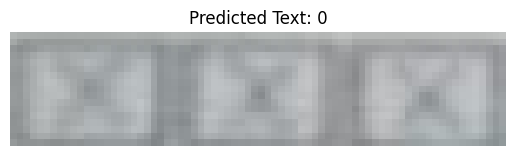

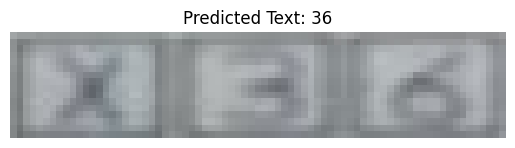

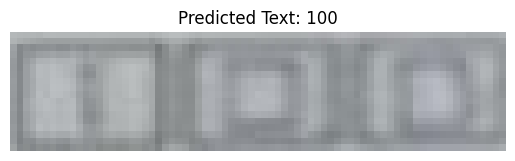

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from ultralytics import YOLO

model = YOLO(ROOT_DIR + 'YOLO_train/weights/best.pt')
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
ocr_model = VisionEncoderDecoderModel.from_pretrained(ROOT_DIR + 'TrOCR_checkpoint')

# Load the image
image_path = '/content/drive/MyDrive/Braincore Intern/Week 2/sirekap-dataset/train/images/0_100_36_jpg.rf.a38222191168d3985e616b10203cd363.jpg'
image = Image.open(image_path).convert('RGB')
results = model(image_path)

# Assuming you already have the bounding box coordinates
for bounding_box in results[0].boxes:
    # Get bounding box coordinates
    x_min, y_min, x_max, y_max = bounding_box.xyxy[0]

    # Convert tensor coordinates to Python numbers
    x_min, y_min, x_max, y_max = x_min.item(), y_min.item(), x_max.item(), y_max.item()

    # Convert coordinates to integers
    x_min, y_min, x_max, y_max = map(int, (x_min, y_min, x_max, y_max))

    # Crop the image using the bounding box coordinates
    cropped_image = image.crop((x_min, y_min, x_max, y_max))

    # # Preprocess the image for the OCR model
    pixel_values = processor(cropped_image, return_tensors="pt").pixel_values
    generated_ids = ocr_model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Display the cropped image
    plt.imshow(cropped_image)
    plt.axis('off')  # Hide axis
    plt.title(f"Predicted Text: {generated_text}")
    plt.show()


# Implementasi Model

In [ ]:
!pip install Flask pyngrok

In [ ]:
!ngrok config add-authtoken 2kriY78RL3u8HReMiqzpE4mGFR0_7gzub33QtMULf2cUL9K7V

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from flask import Flask, request, jsonify, render_template
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import os

# Initialize the Flask app
app = Flask(__name__)

# Load the YOLO model
model = YOLO(ROOT_DIR + 'YOLO_train/weights/best.pt')
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
ocr_model = VisionEncoderDecoderModel.from_pretrained(ROOT_DIR + 'TrOCR_checkpoint')

# Ensure 'uploads' directory exists
if not os.path.exists('uploads'):
    os.makedirs('uploads')

# Route for the home page
@app.route('/')
def home():
    return jsonify({'message': 'Hello World!'})

# Route to handle image uploads and inference
@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file uploaded'}), 400

    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No file selected'}), 400

    # Save the file
    filepath = os.path.join('uploads', file.filename)
    file.save(filepath)

    predictions = []

    try:
        image = Image.open(filepath).convert('RGB')
        results = model(filepath)

        # Assuming you already have the bounding box coordinates
        for bounding_box in results[0].boxes:
            # Get bounding box coordinates
            x_min, y_min, x_max, y_max = bounding_box.xyxy[0]

            # Convert tensor coordinates to Python numbers
            x_min, y_min, x_max, y_max = x_min.item(), y_min.item(), x_max.item(), y_max.item()

            # Convert coordinates to integers
            x_min, y_min, x_max, y_max = map(int, (x_min, y_min, x_max, y_max))

            # Crop the image using the bounding box coordinates
            cropped_image = image.crop((x_min, y_min, x_max, y_max))

            # # Preprocess the image for the OCR model
            pixel_values = processor(cropped_image, return_tensors="pt").pixel_values
            generated_ids = ocr_model.generate(pixel_values)
            generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            predicted_class = results[0].names[int(bounding_box.cls[0].item())]
            predictions.append({
                "classes": predicted_class,
                "predicted_texts": generated_text
            })
    except Exception as e:
        return jsonify({'error': str(e)}), 500
    finally:
        # Optionally remove the uploaded file after processing
        os.remove(filepath)

    # Return the result as JSON
    return jsonify({'predictions': predictions}), 200

In [ ]:
from pyngrok import ngrok

# Run Flask app
http_tunnel = ngrok.connect(5000)
print("Public URL:", http_tunnel.public_url)

app.run()

Public URL: https://f0e8-34-71-95-170.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit



image 1/1 /content/uploads/65_142_2_jpg.rf.827d8f80aa89badd4f7bff7f9caff0b2.jpg: 640x640 1 1, 1 2, 1 3, 227.8ms
Speed: 3.8ms preprocess, 227.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


INFO:werkzeug:127.0.0.1 - - [25/Aug/2024 14:33:08] "POST /predict HTTP/1.1" 200 -
